In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import pickle
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
from scipy.spatial import ConvexHull
from GPyOpt.util.general import get_quantiles
import plotly.graph_objs as go
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
import json
import random

In [2]:
# my own tools
from bgotools.suggest_experiments import suggest_next 
from bgotools.my_acquisitions import EI_below_hull
from bgotools.my_hull_funcs import my_hull_funcs 
from bgotools.set_pool import set_pool
from bgotools.my_acquisitions import EI_hull_area

In [3]:
# for training data
def f(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [4]:
# read the query data formation_energy, clex, corr
data_save = pd.read_csv('./BGO_EI_data',sep='\s+')




In [5]:

data = data_save

In [6]:
# process data 
data['clex()'] = data['clex()'].apply(f)
calculated_data = data['clex()'].notnull()
# calculated data
X_data_all = data[calculated_data]['comp(a)']
Y_data_all = data[calculated_data]['clex()']

len(X_data_all)#number of calculated data

58165

In [7]:
data

,configname,selected,comp(a),formation_energy,clex(),corr(0),corr(1),corr(2),corr(3),corr(4),...,corr(238),corr(239),corr(240),corr(241),corr(242),corr(243),corr(244),corr(245),corr(246),corr(247)
0,SCEL1_1_1_1_0_0_0/0,1,1.000000,0.00000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,SCEL1_1_1_1_0_0_0/1,1,0.875000,-0.03401745,-0.035452,1.0,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,SCEL1_1_1_1_0_0_0/10,1,0.625000,-0.08774064,-0.085923,1.0,0.500000,0.500000,0.000000,0.500000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,SCEL1_1_1_1_0_0_0/100,1,0.625000,-0.06716164,-0.068766,1.0,0.500000,0.000000,0.500000,0.500000,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.5,0.000000,0.000000,0.000000
4,SCEL1_1_1_1_0_0_0/101,1,0.500000,-0.08761127,-0.077558,1.0,1.000000,0.000000,0.500000,0.500000,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.5,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58160,SCEL3_3_1_1_0_1_2/995,1,0.291667,unknown,-0.040703,1.0,0.500000,0.833333,0.666667,0.833333,...,0.055556,0.166667,0.333333,0.333333,0.166667,0.166667,0.0,0.000000,0.166667,0.166667
58161,SCEL3_3_1_1_0_1_2/996,1,0.458333,unknown,-0.064093,1.0,0.500000,0.666667,0.500000,0.500000,...,0.055556,0.166667,0.000000,0.000000,0.055556,0.000000,0.0,0.000000,0.000000,0.000000
58162,SCEL3_3_1_1_0_1_2/997,1,0.375000,unknown,-0.053905,1.0,0.500000,0.666667,0.666667,0.666667,...,0.055556,0.111111,0.000000,0.333333,0.166667,0.000000,0.0,0.111111,0.111111,0.111111
58163,SCEL3_3_1_1_0_1_2/998,1,0.458333,unknown,-0.046311,1.0,0.666667,0.500000,0.500000,0.500000,...,0.055556,0.000000,0.000000,0.000000,0.055556,0.000000,0.0,0.000000,0.055556,0.055556


In [8]:
# get convex hull 
my_hull = my_hull_funcs(X_data_all,Y_data_all)
my_hull.get_bottom_hull()
true_convex_hull, true_convex_hull_index = my_hull.bt_hull_points, my_hull.bt_hull_vertices
hull_function = my_hull.bt_hull_facets
my_hull.shoelace_area()

In [9]:
random.seed(101)
#Number of initial data pool (user)
N_init = 30
init_idxs = random.sample(range(len(data)),N_init)
#init_idxs = random.sample(range(399),N_init)

if data[data['comp(a)']==0].index[0] not in init_idxs:
    init_idxs.append(data[data['comp(a)']==0].index[0])
if data[data['comp(a)']==1].index[0] not in init_idxs:
    init_idxs.append(data[data['comp(a)']==1].index[0])

In [10]:
# start making inputs for GPyOpt
# Y property for training/prediction
Y_name = 'clex()' 
# training pool
N_train = len(init_idxs)
train_index = init_idxs
# design pool
N_design = len(data)
design_index = (range(len(data)))
# corrs 
num_corrs = sum('corr' in s for s in data.columns)
selected_corrs = np.ones(num_corrs) # all correlation functions
# set_pool make the training pool and design pool according to the above settings
my_pool = set_pool(data,train_index,design_index,selected_corrs,Y_name,ternary=False)

In [11]:
len(my_pool.train_X[0])

248

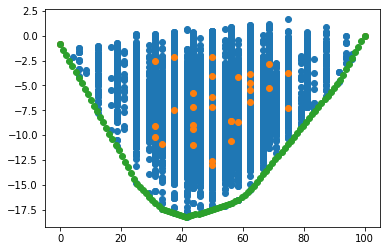

In [12]:
# interactive plot calculated
# visualization of the DFT hull 


plt.scatter(data['comp(a)']*100, data['clex()']*1000/8)
plt.scatter( my_pool.train_comp*100, my_pool.train_Y*1000/8)
hull_x_grid = np.linspace(0,1,100)
plt.scatter(hull_x_grid*100,my_hull.bt_hull_facets(hull_x_grid)*1000/8)
#fig.add_scatter(x = hull_x_grid*100,y = my_Af.predicted_hull.bt_hull_facets(hull_x_grid)*1000/8)
#plt.scatter(hull_x_grid*100,known_hull.bt_hull_facets(hull_x_grid)*1000/8)
plt.show()

In [13]:
# remind properties inside my_pool
'''
my_pool.train_X
my_pool.train_Y 
my_pool.train_comp
my_pool.design_X
my_pool.design_comp
'''
## define some parameters for fitting
max_iteration = 10
tolerance = 1e-3
fixed_noise=1e-6



In [14]:
# remind the initial training data pool 
X_train = my_pool.train_X
Y_train = my_pool.train_Y_nd
done_experiments_id_list = [x for x in my_pool.train_index]
# remind the design data pool
X_design = my_pool.design_X
#design_idxs
# remind the formation energy calculation from the ECIs
#eci_list
#CE_formation_energy
# 
# 
# remind the true ground state line
true_convex_hull_X = data['comp(a)'][true_convex_hull_index]
true_convex_hull_Y = data['clex()'][true_convex_hull_index]
X_list = np.linspace(0,1,100)

In [15]:
GPModelClass=GPy.models.GPRegression

In [16]:
kernel = GPy.kern.RBF(X_train.shape[1], ARD=True)
model = GPModelClass(X_train, Y_train, kernel)
model.Gaussian_noise.variance.constrain_fixed(fixed_noise)
model.optimize_restarts(20, verbose=False)

In [17]:
known_hull = my_hull_funcs(my_pool.train_comp,my_pool.train_Y)
known_hull.get_bottom_hull()
known_hull.shoelace_area()

In [18]:
my_Af = EI_hull_area(my_pool,
                     model,
                     known_hull=known_hull,
                     budget=5,
                     xi=0.0,full_cov=False)

In [19]:
#my_Af.predicted_hull_configs

In [20]:
my_Af.EI()

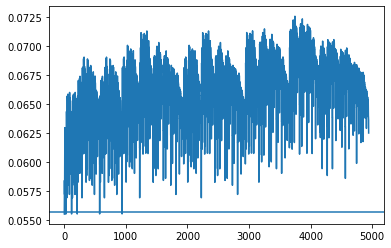

In [21]:
plt.plot(my_Af.areas)
plt.axhline(my_Af.known_hull_area)
#plt.plot(my_Af.areas,my_Af.ei)
#plt.scatter(my_Af.areas,my_Af.areas_var)

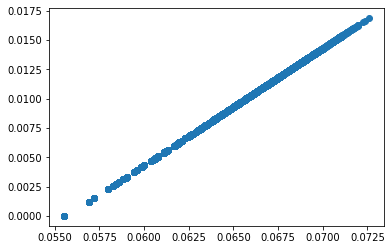

In [22]:
plt.scatter(my_Af.areas,my_Af.ei)

In [23]:
batch_size = []
for batch in my_Af.config_combinations:
    batch_size.append(len(batch))
    

In [24]:
my_Af.config_combinations[-1]

[8466, 8355, 7490, 112, 39723]

In [25]:
my_Af.config_combinations[-10:]

[[12625, 8466, 8355, 7490, 39723],
 [12625, 8466, 8355, 112, 39723],
 [12625, 8466, 7490, 112, 39723],
 [12625, 8355, 7490, 112, 39723],
 [125, 8466, 8355, 7490, 112],
 [125, 8466, 8355, 7490, 39723],
 [125, 8466, 8355, 112, 39723],
 [125, 8466, 7490, 112, 39723],
 [125, 8355, 7490, 112, 39723],
 [8466, 8355, 7490, 112, 39723]]

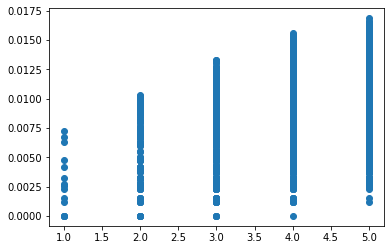

In [26]:
plt.scatter(batch_size,my_Af.ei)

In [27]:
test_subhull = [x for x in my_Af.all_sub_hulls if len(x.bt_hull_points)>=6]

In [28]:
len(test_subhull)

3609

In [31]:
train_index_update = my_pool.train_index

In [33]:
#start iterations from here
train_index_update = train_index
my_pool_update = set_pool(data,train_index,design_index,selected_corrs,Y_name,ternary=False)
print(len(my_pool_update.train_comp),len(my_pool_update.train_Y))
saved_model_list = []
next_experiment_id_list = []
next_experiment_idxs_list_non_duplicated = []
af_max_ei_list = []
af_ei_list = []
# Af_evolve documents all the Af/EI for all iterations
# in an Af of one iteration, we can get 
# 1. EI of hull
# 2. predicted area
# 3. predicted mean/variance of configurations
# 4. predicted hull -> all configurations
# 5. predicted hull subsets -> combinations
# 6. predicted hull functions -> for plotting the hull

Af_evolve = []


32 32


In [34]:


# start optimization 
#for it in range(max_iteration):
for it in range(15):
    print('> Iteration: {}'.format(it))
    print('Number of data points observed: {}'.format(len(my_pool_update.train_Y_nd)))
    # setup model
    kernel = GPy.kern.RBF(my_pool_update.train_X.shape[1], ARD=True)
    model = GPModelClass(my_pool_update.train_X, my_pool_update.train_Y_nd, kernel)
    if fixed_noise is not None:
        model.Gaussian_noise.variance.unconstrain()
        model.Gaussian_noise.variance.constrain_fixed(fixed_noise)
        
    # start fitting
    model.optimize_restarts(20, verbose=False)
    
    # fitting finished, get EI
    known_hull = my_hull_funcs(my_pool_update.train_comp,my_pool_update.train_Y)
    #####
    #####
    #####
    my_Af = EI_hull_area(my_pool_update,
                     model,
                     known_hull=known_hull,
                     budget=5,
                     xi=0.0,full_cov=False)
    my_Af.EI()
    
    try:
        ei = my_Af.ei 
        i = np.argmax(ei)
        af_max_ei0 = ei[i]

        af_max_ei_list.append(af_max_ei0)
    except:
        # restart fitting
        print('No hull found, refit.')
        model.optimize_restarts(25, verbose=False)
        
        # fitting finished, get EI
        known_hull = my_hull_funcs(my_pool_update.train_comp,my_pool_update.train_Y)
        #####
        #####
        #####
        my_Af = EI_hull_area(my_pool_update,
                         model,
                         known_hull=known_hull,
                         budget=5,
                         xi=0.0,full_cov=False)
        my_Af.EI()
        ei = my_Af.ei 
        i = np.argmax(ei)
        af_max_ei0 = ei[i]
        af_max_ei_list.append(af_max_ei0)
    #####
    #####
    #####
    # get the predicted hull configuration subsets according to EI ranking
    # can be smarter !!!!! use pareto front?
    next_experiment_idxs_non_duplicated = my_Af.config_combinations[sorted(range(len(my_Af.ei)), key=lambda i: my_Af.ei[i],reverse=True)[0]]
    try:
        _2_hull = my_Af.config_combinations[sorted(range(len(my_Af.ei)), key=lambda i: my_Af.ei[i],reverse=True)[1]]
        _3_hull = my_Af.config_combinations[sorted(range(len(my_Af.ei)), key=lambda i: my_Af.ei[i],reverse=True)[2]]
        if len(next_experiment_idxs_non_duplicated) <=3: 
            next_experiment_idxs_non_duplicated = next_experiment_idxs_non_duplicated + _2_hull
        if len(next_experiment_idxs_non_duplicated) <=3: 
            next_experiment_idxs_non_duplicated = next_experiment_idxs_non_duplicated + _3_hull
    except:
        pass
    #####
    #####
    #####
    next_experiment_idxs_non_duplicated = list(dict.fromkeys(next_experiment_idxs_non_duplicated))
    # determine whether next fitting is necessary 
    '''if af_max_ei0 / af_max_ei_list[0] <= tolerance:
        print('*** Converged (af[i] / afmax0 = {0:1.7f}) < {1:e}'.format(af_max_ei0 / af_max_ei_list[0], tolerance))
        X_of_all_trained = X_train
        break'''
    # append predicted configurations to the updating training pool (observations)
    train_index_update = train_index_update + next_experiment_idxs_non_duplicated
    train_index_update = list(dict.fromkeys(train_index_update))
    my_pool_update = set_pool(data,train_index_update,design_index,selected_corrs,Y_name,ternary=False)
    saved_model_list.append(model)
    Af_evolve.append(my_Af)
    print('Selected Structures: {}'.format(next_experiment_idxs_non_duplicated))
    
    print('Max EI = {}'.format(af_max_ei0 ))
    print('Min Energy Observed: {}'.format(my_pool_update.train_Y.min()))

> Iteration: 0
Number of data points observed: 32
Selected Structures: [54367, 52937, 22227, 12625, 8466]
Max EI = 0.016870864813672393
Min Energy Observed: -0.10406472
> Iteration: 1
Number of data points observed: 37
Selected Structures: [23600, 51797, 51686, 51664, 59]
Max EI = 0.024335426171908585
Min Energy Observed: -0.13442719
> Iteration: 2
Number of data points observed: 42
Selected Structures: [51459, 51675, 8355, 51830, 54356]
Max EI = 0.010129309618967144
Min Energy Observed: -0.14346483
> Iteration: 3
Number of data points observed: 47
Selected Structures: [23, 54287, 54176, 54065]
Max EI = 0.0009652018459794104
Min Energy Observed: -0.14596631
> Iteration: 4
Number of data points observed: 51
Selected Structures: [30561, 64, 39484]
Max EI = 0.0
Min Energy Observed: -0.14596631
> Iteration: 5
Number of data points observed: 54
Selected Structures: [54855, 53954, 51002, 52296, 54522]
Max EI = 0.0044526810250267584
Min Energy Observed: -0.14596631
> Iteration: 6
Number of da

KeyboardInterrupt: 

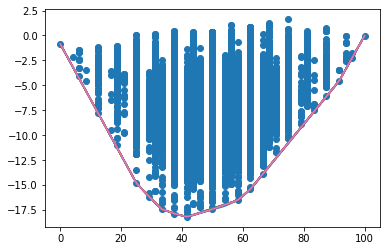

In [38]:
# interactive plot calculated
# visualization of the DFT hull 
my_Af = Af_evolve[7]

#plt.scatter(data['comp(a)']*100, data['clex()']*1000/8)
#plt.scatter( my_pool.train_comp*100, my_pool.train_Y*1000/8)
hull_x_grid = np.linspace(0,1,100)
plt.plot(hull_x_grid*100,my_hull.bt_hull_facets(hull_x_grid)*1000/8)
for hull_i in my_Af.all_sub_hulls[:20]:
    plt.plot(hull_x_grid*100,hull_i.bt_hull_facets(hull_x_grid)*1000/8)
plt.plot(hull_x_grid*100,my_Af.predicted_hull.bt_hull_facets(hull_x_grid)*1000/8)
plt.scatter(my_Af.design_comp*100,my_Af.predictive_mean*1000/8)
#plt.scatter(hull_x_grid*100,known_hull.bt_hull_facets(hull_x_grid)*1000/8)
plt.show()

In [39]:
Af_check_ = Af_evolve[0]
pool_check_ = set_pool(data,Af_check_.predicted_hull_configs,design_index,selected_corrs,Y_name,ternary=False) 


In [40]:
Y_check_,Y_cov_check_ = Af_check_.model.predict(pool_check_.train_X,full_cov=True)

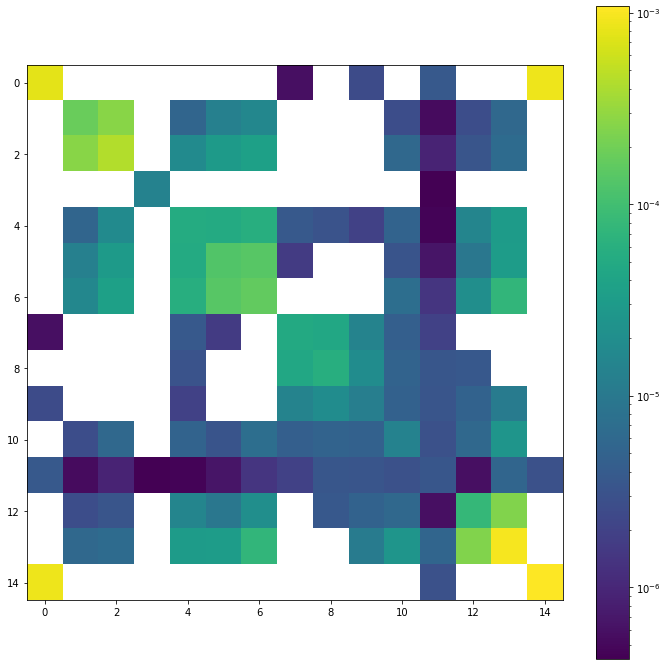

In [41]:
import matplotlib 
plt.figure(figsize=(12,12))
im = plt.imshow(Y_cov_check_, norm=matplotlib.colors.LogNorm())
plt.colorbar(im)


In [43]:
#Y_cov_check_

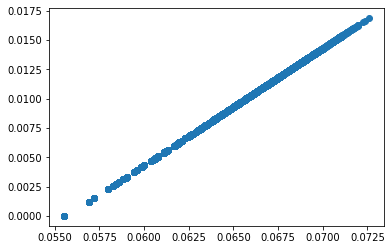

In [44]:
plt.scatter(Af_check_.areas,Af_check_.ei)

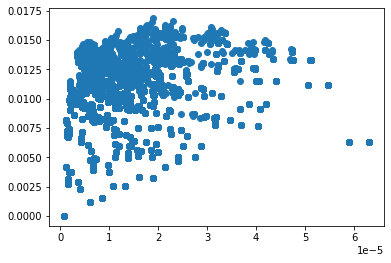

In [45]:
plt.scatter(Af_check_.areas_var,Af_check_.ei)

In [47]:
def GSLError(True_GSL,Fit_GSL):
    #print(np.sqrt(np.trapz(GSL_difference**2)))
    #print(np.sqrt(np.trapz(True_GSL**2)))
    GSL_difference = Fit_GSL - True_GSL
    GSL_ERROR = np.sqrt(np.trapz(GSL_difference**2))/np.sqrt(np.trapz(True_GSL**2))
    return GSL_ERROR